In [1]:
import os
import cv2
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from deepface import DeepFace
from deepface.commons.distance import findCosineDistance



In [9]:
# Set the paths for the dataset
dataset_path = "/Users/stellafazioli/Documents/Casia-evalu/impostor"

# Initialize DeepFace model (Facenet512)
model = "Facenet"


In [10]:
# Collect image paths and labels
image_paths = []
labels = []
class_folders = [subfolder for subfolder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, subfolder))]
for class_folder in class_folders:
    class_path = os.path.join(dataset_path, class_folder)
    image_files = [file for file in os.listdir(class_path) if file.endswith(".jpg") or file.endswith(".png") and not file.startswith(".")]
    image_paths.extend([os.path.join(class_path, img) for img in image_files])
    
    # Assign binary labels
    for img in image_files:
        img_path = os.path.join(class_path, img)
        if img.startswith(class_folder):
            labels.append(1)  # Genuine image
        else:
            labels.append(0)  # Impostor image

In [11]:
# Encode the labels as integers
#label_encoder = LabelEncoder()
#labels = label_encoder.fit_transform(labels)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


In [12]:
# Compute similarity scores
similarities = []
similarity_labels = []
for i in range(len(X_test)):
    img1 = cv2.imread(X_test[i])
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #print(img1)
    for j in range(i+1, len(X_test)):
        img2 = cv2.imread(X_test[j])
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        
        if y_test[i] == y_test[j]:
            similarity_labels.append(1)  # Genuine image pair
        else:
            similarity_labels.append(0)  # Impostor image pair

        

        # Calculate similarity score using cosine distance
        # Calculate similarity score using cosine distance
        img1_representation = DeepFace.represent(img1, model_name=model,enforce_detection=False)[0]['embedding']
        img2_representation = DeepFace.represent(img2, model_name=model,enforce_detection=False)[0]['embedding']
        
        score = findCosineDistance(img1_representation, img2_representation)
        similarities.append(score)


KeyboardInterrupt: 

In [ ]:
output_file = '/Users/stellafazioli/Downloads/similarities_score_casia.txt'

# Save the similarity scores to file
with open(output_file, 'w') as file:
    file.write("similarity:")
    for score in similarities:
        file.write(str(score) + '\n')
    file.write("labels:")
    for label in similarity_labels:
        file.write(str(score) + '\n')

In [109]:
print(len(similarity_labels))

9591


In [105]:
from sklearn.preprocessing import label_binarize
n_classes = len(np.unique(y_train))-1
y_test_binary = label_binarize(y_test, classes=np.arange(n_classes))


In [102]:
similarities = np.array(similarities)
print(len(y_test_binary))


139


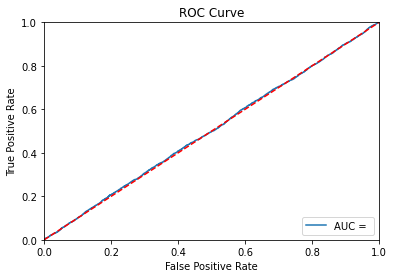

In [113]:
from scipy.special import softmax

# Compute ROC curve and AUC score
similarities = np.array(similarities)
fpr, tpr, thresholds = roc_curve(similarity_labels, similarities.ravel())
similarities_ = similarities.reshape(-1, 1) 
probabilities = softmax(similarities_, axis=1)

auc_score = roc_auc_score(similarity_labels, probabilities,multi_class='ovr')

# Plot ROC curve
#plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot(fpr, tpr, label=f"AUC = ")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()